# Comparison of HulC, Wald and Bootstrap intervals:

Adapted from Comparison of HulC and Wald intervals 1.ipynb

Note that added "seed" argument in foo() and the seed in each simulation is the repetition "rep".

## Simple Linear Regression

In [1]:
### HulC.R contains all the functions related to the HulC procedure.
source("HulC.R")

### loading necessary packages for computation and plotting.
library("sandwich")
library(data.table)
library(ggplot2)
library("cowplot")
library("gridExtra")
library("repr")
library("boot")

In the following, we will compare the HulC and Wald confidence intervals for the slope in a potentially misspecified linear model. We have observations $(X_i, Y_i), 1\le i\le n$ from the model
\begin{equation*}
Y_i = 1 + 2X_i + \gamma X_i^{1.7} + \exp(\gamma X_i)\xi_i,
\label{eq:DGP}\tag{DGP}
\end{equation*}
where $\xi_i$ is a standard Gaussian random variable independent of $X_i$. The estimator we use is the classical OLS linear regression estimator:
$$(\widehat{\alpha}, \widehat{\beta}) := \underset{(\alpha,\beta)}{\text{argmin}} \sum_{i=1}^n (Y_i - \alpha - \beta X_i)^2.$$
The target of $(\widehat{\alpha}, \widehat{\beta})$ is given by
$$(\alpha_{\gamma}, \beta_{\gamma}) := \underset{(\alpha,\beta)}{\text{argmin}} \mathbb{E}_{\gamma}[(Y - \alpha - \beta X)^2],$$
where $\mathbb{E}_{\gamma}$ is the expectation with respect to $(X, Y)$, when they are also generated from the model \eqref{eq:DGP}. Our target of inference is the parameter $\beta_{\gamma}$ for $\gamma$ in an equi-spaced grid of size 5 between $0$ and $1$. Note that for $\gamma = 0$, the data generating model \eqref{eq:DGP} is a well-specified linear model. 

It is important to note that $(\alpha_{\gamma}, \beta_{\gamma}) \neq (1, 2)$ for any $\gamma > 0$. We find the values of $\beta_{\gamma}$ for $\gamma$ in the grid by generating $10^8$ samples from the model \eqref{eq:DGP} and performing least squares regression. The following code performs this operation.  

In [2]:
## The following code is precomputed because it is computationally expensive.
gamma_seq <- seq(0, 1, length = 11)
## Finding the projection parameter values using 
## Monte Carlo simulation
# proj_beta <- rep(0, length(gamma_seq))
# names(proj_beta) <- paste0("gamma_", gamma_seq)
# for(idx in 1:length(gamma_seq)){
#   beta0 <- 1
#   beta1 <- 2
#   nsamp <- 1e08
#   gamma <- gamma_seq[idx]
#   x <- runif(nsamp, 0, 10)
#   y <- beta0 + beta1*x + gamma*x^{1.7} + exp(gamma*x)*rnorm(nsamp)
#   data <- cbind(1, x, y)
#   proj_beta[idx] <- unname(lm.fit(data[,c(1,2)], data[,3])$coefficients[2])
# }
proj_beta <- c(1.9999734639072, 2.51173229253559, 3.02342290681397, 3.53556599615292,
               4.04666366253353, 4.55889962901337, 5.07067617427089, 5.59357477000109,
               6.11690960295203, 6.64458369879289, 7.00568835897238)
names(proj_beta) <- paste0("gamma_",gamma_seq)

Now that we found the projection parameter values (i.e., $\beta_{\gamma}$ for $\gamma$ in the grid), our aim is to construct confidence intervals to contain $\beta_{\gamma}$. Note that $\widehat{\beta}$ is consistent for $\beta_{\gamma}$ whenever the data is generated from \eqref{eq:DGP}. The classical Wald interval with sandwich covariance matrix is an asymptotically valid confidence interval for $\beta_{\gamma}$. Because the limiting distribution is Gaussian, the asymptotic median bias of $\widehat{\beta}$ is zero and hence HulC can be applied $\Delta = 0$; this is Algorithm 1 in the paper. The following function (`foo`) generates data from \eqref{eq:DGP} and computes the HulC and Wald confidence intervals at the confidence of $95\%$.  

## Comparison with bootstrap

In [3]:
foo <- function(nsamp, gamma, name, alpha = 0.05, seed = 1){
  
  set.seed(seed)
  
  beta0 <- 1
  beta1 <- 2
  x <- runif(nsamp, 0, 10)
  y <- beta0 + beta1*x + gamma*x^{1.7} + exp(gamma*x)*rnorm(nsamp)
  data <- cbind(x, y)
  if(name == "HulC"){
    estimate <- function(dat_tmp){
      fit <- lm(dat_tmp[,2] ~ dat_tmp[,1])
      return(unname(fit$coeff)[2])
    }
    tmp <- as.vector(HulC(data, estimate, alpha = alpha, Delta = 0, dim = 1)$CI)
  }
  if(name == "Wald"){
    mod <- lm(data[,2] ~ data[,1])
    est <- unname(mod$coeff[2])
    sd_est <- sqrt(vcovHC(mod, type = "HC")[2,2])
    tmp <- est + c(-1, 1)*qnorm(1-alpha/2)*sd_est
  }
  if(name == "basic_boot"){
    boot_coef <- function(DATA, indices){
      dat_xy <- DATA[indices,]
      mod <- lm(dat_xy[,2] ~ dat_xy[,1])
      m <- unname(mod$coeff[2])
      v <- sqrt(vcovHC(mod, type = "HC")[2,2])
      return(c(m, v))
    }        
    boot_replicates <- boot(data, boot_coef, 500)
    #         print(boot_replicates)
    tmp <- boot.ci(boot_replicates, conf = 1 - alpha, type = "basic")$basic[c(4,5)]
  }
  if(name == "perc_boot"){
    boot_coef <- function(DATA, indices){
      dat_xy <- DATA[indices,]
      mod <- lm(dat_xy[,2] ~ dat_xy[,1])
      m <- unname(mod$coeff[2])
      v <- sqrt(vcovHC(mod, type = "HC")[2,2])
      return(c(m, v))
    }        
    boot_replicates <- boot(data, boot_coef, 500)
    #         print(boot_replicates)
    tmp <- boot.ci(boot_replicates, conf = 1 - alpha, type = "perc")$percent[c(4,5)]
  }
  return(tmp)
}

## HulC confidence interval
print("HulC confidence interval:")
foo(100, 0, "HulC", alpha = 0.05)

## Wald confidence interval
print("Wald confidence interval:")
foo(100, 0, "Wald", alpha = 0.05)

## Studentized bootstrap confidence interval
print("Studentized bootstrap confidence interval:")
foo(100, 0, "basic_boot", alpha = 0.05)

[1] "HulC confidence interval:"


[1] 1.963814 2.128876

[1] "Wald confidence interval:"


[1] 1.961144 2.101325

[1] "Studentized bootstrap confidence interval:"


[1] 1.962894 2.107093

# Simulation
The following code compares HulC, Wald, and Bootstrap confidence intervals in terms of coverage and width.

In [4]:
job_id <- 2012557

# if the simulation results do not exist
if(!file.exists(paste0("../output/boot_cov_", job_id, ".csv"))) {

    nsamp_seq <- c(20, 50, 100, 1000)
    ## Simulation
    ## Setting seed for reproducibility.
    set.seed(2021)
    name_seq <- c("HulC", "Wald", "basic_boot", "perc_boot")
    nrep <- 500
    rep_seq <- 1:nrep
    grid <- expand.grid(nsamp_seq, gamma_seq, name_seq, rep_seq)
    colnames(grid) <- c("nsamp", "gamma", "name", "rep")
    width_mat <- data.frame(value = rep(0, nrow(grid)), gamma = grid$gamma, nsamp = grid$nsamp, name = grid$name, rep = grid$rep)
    cov_mat <- width_mat

    for(idx in 1:nrow(grid)){
        #if(idx%%1000 == 0){
        #  print(idx)
        #}
        tmp <- foo(grid[idx,1], grid[idx,2], grid[idx,3], alpha = 0.05, seed = grid[idx,4])
        width_mat[idx, 1] <- (tmp[2] - tmp[1])
        true_beta <- proj_beta[paste0("gamma_", grid[idx,2])]
        cov_mat[idx, 1] <- (tmp[1] <= true_beta && true_beta <= tmp[2])
    }
    
    fwrite(width_mat, paste0("../output/boot_cov_", job_id, ".csv"))
    fwrite(ret_width, paste0("../output/boot_width_", job_id, ".csv"))
    
}

## Plotting
The following code provides a visual representation of the results.

In [5]:
ret_cov <- fread(paste0("../output/boot_cov_", job_id, ".csv"))
ret_width <- fread(paste0("../output/boot_width_", job_id, ".csv"))

In [6]:
# get the HulC/Wald ratio
ret_width_wide <- dcast(ret_width, nsamp + gamma + rep ~ name, value.var = "value")
ret_width_wide[, ratio := HulC/Wald]
ret_width_wide[, type := "Width Ratio"]

# get coverage probability
ret_cov_agg <- ret_cov[,.(cov = mean(value)), by = .(nsamp, gamma, name)]
ret_cov_agg[, type := "Coverage"]
ret_cov_agg[, name := factor(name, levels = c("HulC", "Wald", "basic_boot", "perc_boot"))]

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


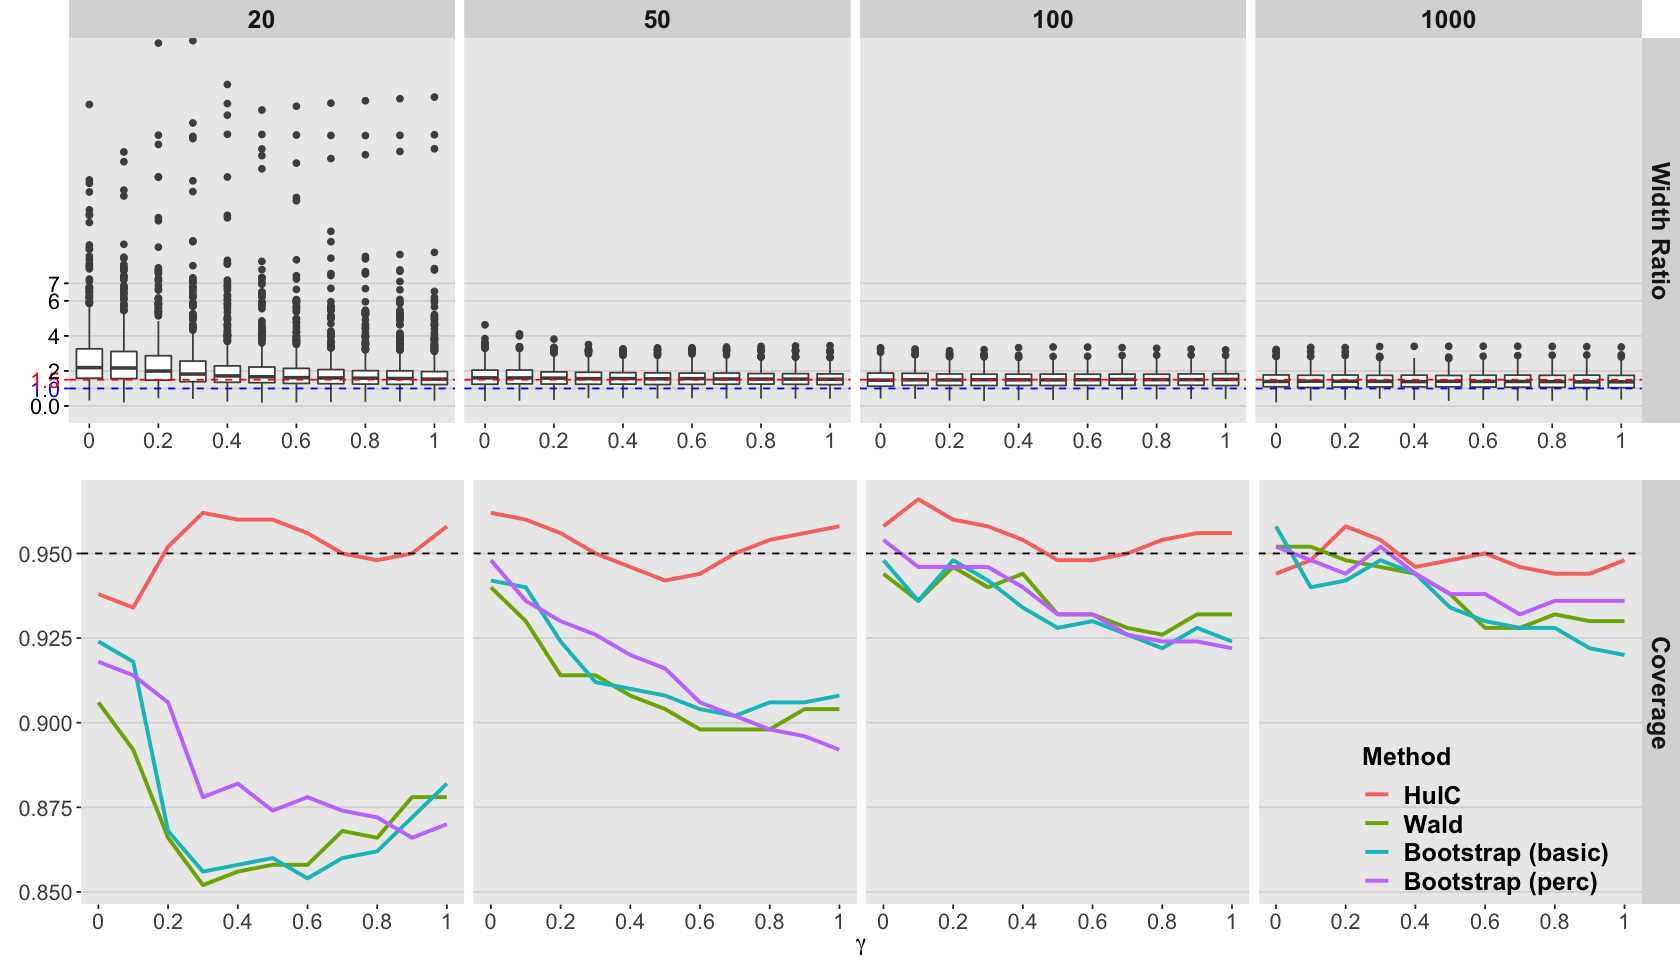

In [8]:
# width ratio plot
g1 <- ggplot(ret_width_wide, aes(x = as.factor(gamma), y = ratio)) +
    geom_boxplot(color="gray30")+ 
    geom_hline(yintercept = 1, linetype = "dashed", col = "blue") +
    geom_hline(yintercept = 1.5, linetype = "dashed", col = "red") +
    facet_grid(type~as.factor(nsamp)) + 
    labs(x = "",y="")+
    coord_cartesian(ylim=c(0, 20))+
    theme(plot.margin=unit(c(0,0,0,.05), "cm"))+ 
    background_grid(major="y", minor="none") +
    scale_x_discrete(breaks=seq(0, 1, .2), 
                      labels=seq(0, 1, .2)) +
    scale_y_continuous(breaks=c(0, 1, 1.5, 2, 4, 6, 7), 
                    labels=c("0.0", "1.0", "1.5", "2", "4", "6", "7")) +
    theme(axis.text.x=element_text(size = 13),
                axis.text.y=element_text(size=13,color = c("black", "blue", "red", "black", "black", "black", "black")),
                axis.text=element_text(size=12),
                axis.title=element_text(size=15,face="bold"),
                strip.text = element_text(size=15,face = "bold"),
                axis.ticks.y = element_line(color = c("black", "blue", "red", "black", "black", "black", "black"),
                                    size = c(.5,0.5,0.5,.5,.5,.5,.5)))


# Coverage plot
g2 <- ggplot(ret_cov_agg, aes(x=gamma, y =cov, col=name, group= as.factor(name))) +
#   ylim(.8, 0.96)+
  geom_line(size = 1.1)+ 
  geom_hline(yintercept = 0.95, linetype = 2)+
  facet_grid(type~as.factor(nsamp)) + 
#   geom_line(nominal_coverage, mapping = aes(x = x0, y = y0), linetype = 2) + 
  theme(plot.margin=unit(c(0,0,0,-.2), "cm"),
        legend.position=c(0.9,0.2),
        strip.background.x = element_blank(),
        legend.margin = margin(10, 10, 10, 10),
        axis.text.x=element_text(size = 13),
        axis.text.y=element_text(size=13),
        axis.text=element_text(size=12),
        legend.text=element_text(size=15, face = "bold"),
        legend.title=element_text(size = 15, face = "bold"),
        strip.text.x = element_blank(),    
        axis.title=element_text(size=15,face="bold"),
        strip.text = element_text(size=15,face = "bold"),
        legend.key=element_blank(),
        legend.background=element_blank())+ 
  labs(y="", x=expression(gamma))+
  background_grid(major="y", minor="none")+
  scale_color_discrete("Method",labels = c("HulC", "Wald", "Bootstrap (basic)", "Bootstrap (perc)") )+
  scale_x_continuous(breaks=seq(0, 1, .2), 
                      labels=seq(0, 1, .2))

# two plots
options(repr.plot.width=14, repr.plot.height=8)
g <- grid.arrange(g1,g2)

ggsave("../fig/boot_simple_reg.pdf", g, width = 14, height = 8)